# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`\*. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

\***Renamed the file to "2_Dataset.csv"** 

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

C:\Users\Kaizer\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mpldates
import mplleaflet
import numpy as np
import pandas as pd
%matplotlib inline

#Read in data and convert Date to DateTime format
# df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
df = pd.read_csv('2_Dataset.csv', usecols=[x for x in range(1, 5)])
df['Date'] = pd.to_datetime(df['Date'])

#Normalize the values
df['Data_Value'] = df['Data_Value'].apply(lambda x: x / 10) 

#Remove leap days from records
df = df[df['Date'].apply(lambda x: False if x.month == 2 and x.day == 29 else True)]

In [3]:
#Get the Year and Month-Day for processing
df['Year'] = df['Date'].apply(lambda x: x.year)
df['Month-Day'] = df['Date'].apply(lambda x: x.strftime("%m-%d"))
# df.head()

In [4]:
# #Retrieve records from 2005 to 2014
df0514 = df[(df["Year"] >= 2005) & (df["Year"] <= 2014)]

#Filter the records with highest TMAX element
df0514_max = df0514[df0514['Element'] == 'TMAX'].groupby('Month-Day')['Data_Value'].max()

#Filter the records with the lowest TMAX element
df0514_min = df0514[df0514['Element'] == 'TMIN'].groupby('Month-Day')['Data_Value'].min()

#Combine the two records df0514_max and df0514_min 
df0514_max_min = pd.concat([df0514_max, df0514_min], keys=['High', 'Low'], axis=1)
# df0514_max_min.head()

In [5]:
#Retrive records only from 2015 
df15 = df[df["Year"] == 2015]

#Retrieves the records in 2015 which broke the record high from 2005-2014
df15_max = df15[df15['Element'] == 'TMAX'].groupby('Month-Day')['Data_Value'].max()
# df15_max = pd.merge(df15_max.to_frame(), df0514_max_min['High'].to_frame(), left_index=True, right_index=True) #Old Version pd
df15_max = pd.merge(df15_max, df0514_max_min['High'], on='Month-Day')
df15_max = df15_max[df15_max['Data_Value'] > df15_max['High']]

#Retrieves the records in 2015 which broke the record low from 2005-2014
df15_min = df15[df15['Element'] == 'TMIN'].groupby('Month-Day')['Data_Value'].min()
#df15_min = pd.merge(df15_min.to_frame(), df0514_max_min['Low'].to_frame(), left_index=True, right_index=True) #Old Version pd
df15_min = pd.merge(df15_min, df0514_max_min['Low'], on='Month-Day')
df15_min = df15_min[df15_min['Data_Value'] < df15_min['Low']]

#Set the appropriate timelines for plotting
observation_dates = np.arange('2015-01-01', '2016-01-01', dtype='datetime64[D]')
observation_dates = np.array(list(map(pd.to_datetime, observation_dates)))

#Format the 2015 records' date to fit the appropriate timelines for plotting
df15_max = df15_max.rename(index=lambda x: pd.to_datetime('2015-'+str(x)))
df15_min = df15_min.rename(index=lambda x: pd.to_datetime('2015-'+str(x)))

C:\Users\Kaizer\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


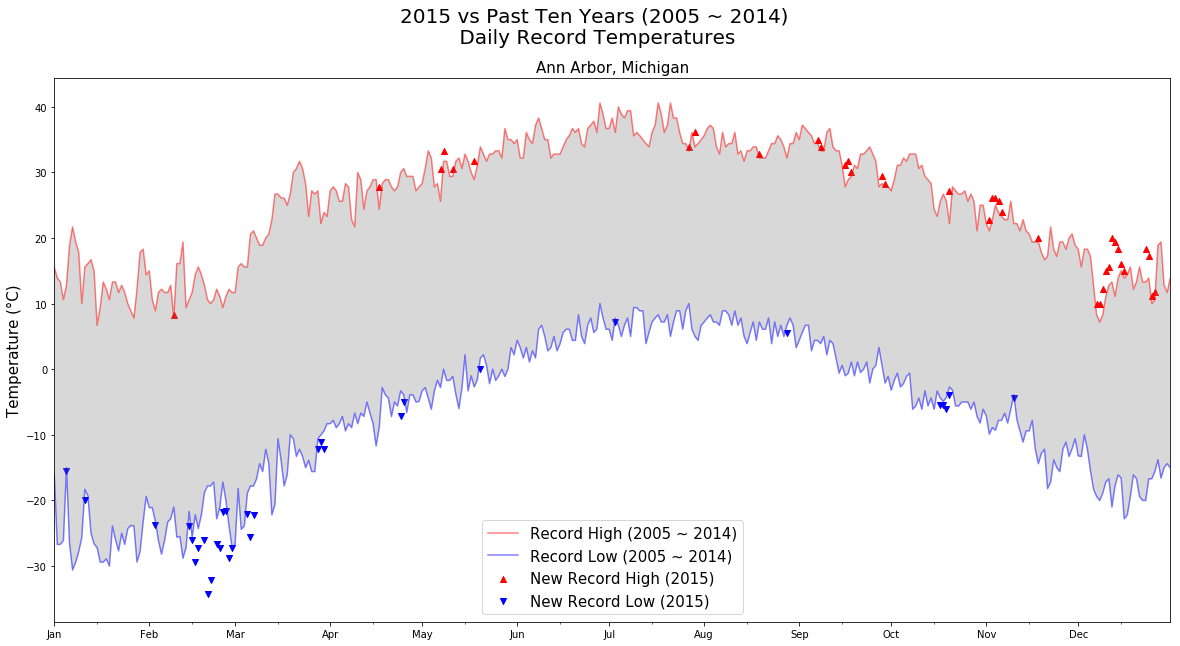

In [6]:
#Plot the graph
plt.Figure()
plt.figure(figsize=(20,10))

#Plot the daily record high and low temperatures from 2005 to 2014
plt.plot(observation_dates, df0514_max, color='red', linestyle='-', alpha=0.5) 
plt.plot(observation_dates, df0514_min, color='blue', linestyle='-', alpha=0.5)

#Plot the daily high and low temperatures in 2015 that broke the records from 2005 to 2014
plt.scatter(df15_max.index, df15_max['Data_Value'], c='r',  marker='^')
plt.scatter(df15_min.index, df15_min['Data_Value'], c='b', marker='v')

#Fill the area between record high and low from 2005 to 2014
plt.fill_between(observation_dates, df0514_max, df0514_min, facecolor='grey', alpha = 0.3)

#Format the x-axis to display months
plt.gca().xaxis.set_major_formatter(mpldates.DateFormatter('%b'))
plt.gca().xaxis.set_minor_locator(mpldates.MonthLocator(bymonthday=15))
plt.gca().xaxis.set_view_interval(vmin = mpldates.date2num(observation_dates[0]), vmax= mpldates.date2num(observation_dates[-1]), ignore=True)

#Add details to the plot
plt.suptitle("2015 vs Past Ten Years (2005 ~ 2014)\n Daily Record Temperatures", fontsize=20)
plt.title("Ann Arbor, Michigan", fontsize=15)
plt.ylabel('Temperature (°C)', fontsize=15)
plt.legend(['Record High (2005 ~ 2014)','Record Low (2005 ~ 2014)','New Record High (2015)','New Record Low (2015)'], loc=8, fontsize=15)

plt.savefig('Assignment2.png')
plt.show()